# Seminário: Python de A a Z
## Titanic - um evento infortuito?

Em 1912, um malogrado evento ficou na história pelos piores motivos, devido ao acidente e respetivo afundamento do navio Titanic, levando à perda incalculável do maior navio de passageiros na altura e de mais de 1500 passageiros. 
Aqueles que sobreviveram podem considerar-se afortunados. 
Ou será que a sua sobrevivência não terá sido assim tanto uma obra do acaso?
Bem-vindo a este projeto, onde iremos tentar prever o desfecho de 418 desses passageiros do Titanic, conhecendo os dados dos restantes passageiros.

![Markdown Logo is here.](https://cdn.britannica.com/72/153172-050-EB2F2D95/Titanic.jpg)

#### 1. Setup
Vamos começar por importar as bibliotecas que iremos precisar:

In [5]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#### 2. Importação e aquisição de dados

In [10]:
train_data = pd.read_csv(r'data\train.csv')
test_data = pd.read_csv(r'data\test.csv')
combined = pd.concat([train_data, test_data])
combined['type'] = combined.apply(lambda x: 'train' if pd.notnull(x['Survived']) else 'test', axis = 1)
solution = pd.read_csv(r'data\solution.csv', sep=";", header=0)
combined

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test


De seguida, iremos começar por observar os dados adquiridos

In [11]:
print(train_data.describe())
# from pandas_profiling import ProfileReport
# profile = ProfileReport(train_data, title='Titanic Report', explorative=True)
# profile.to_file('titanic_report.html')

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


Recomenda-se a biblioteca **'ProfileReport'** para gerar relatórios mais completos sobre os dados (ver ficheiro 'titanic_report.html')

#### 3. Processamento e exploração de dados

A partir deste momento, iremos processar os dados, tentando explorar a informação que estes contêm, de forma a conduzir a nossa análise.

In [12]:
sum(train_data['Survived']) / len(train_data['Survived'])

0.3838383838383838

Criação de uma função que nos permite calcular a taxa de sobrevivência:

In [13]:
def survival(df):
    result = sum(df['Survived']) / len(df['Survived']) if len(df['Survived']) > 0 else 0
    return result

In [14]:
survival_rate = survival(train_data)
print(f'A taxa de sobrevivência no Titanic foi de {"{0:.2%}".format(survival_rate)}')

A taxa de sobrevivência no Titanic foi de 38.38%


In [15]:
pclass = train_data.groupby('Pclass').apply(survival)
print(pclass)

Pclass
1    0.629630
2    0.472826
3    0.242363
dtype: float64


Não é muito visual, por isso vamos colocar os dados em gráficos que nos ajudem a interpretá-los!

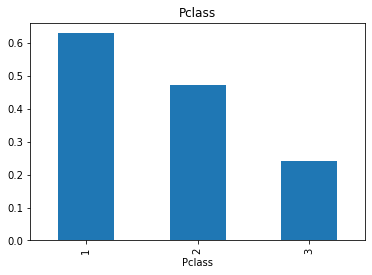

In [16]:
def show_survival(field):
    combined.query('type == "train"').groupby(field).apply(survival).plot.bar(title=field)

show_survival('Pclass')

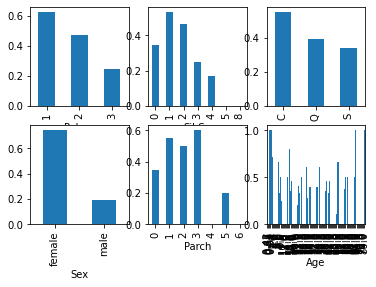

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3)
graph = 0
for i in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Age']:
    combined.query('type == "train"').groupby(i).apply(survival).plot(kind='bar',ax=axes[graph % 2, graph // 2])
    graph = graph + 1

#### 3.1 Extração de características (*feature engineering*)

Iremos agora extrair algumas características dos dados, que nos permitem obter mais informação, como por exemplo:
1. A **idade** é uma variável contínua
2. O **nome** é um campo de texto único, mas que contém informação importante
3. A **cabine** poderá ser resumida em 'blocos'

C:\Users\jose.guimaraes\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jose.guimaraes\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


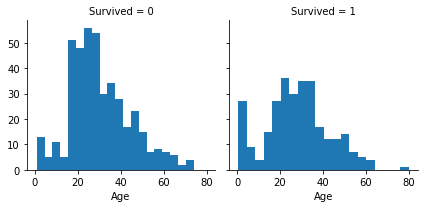

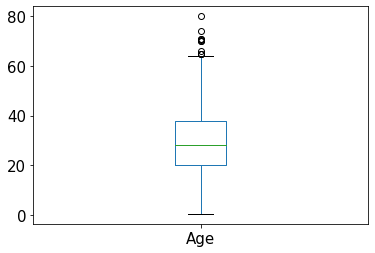

In [18]:
g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()
train_data[['Age']].boxplot(grid=False, fontsize=15)
plt.show()

In [19]:
def classify(df, field, n_bins):
    feature_class = np.linspace(0, max(df[field]), n_bins + 1)
    labels = [f'{round(i,2)}-{round(j,2)}' for i, j in zip(feature_class[:-1], feature_class[1:])] 
    df[field + '_Class'] = pd.cut(df[field], bins=feature_class, labels=labels)
    return df

In [20]:
classify(combined, 'Age', 8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type,Age_Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,20.0-30.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,30.0-40.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,20.0-30.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,30.0-40.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,30.0-40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test,NaN
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test,30.0-40.0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test,30.0-40.0
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test,NaN


In [21]:
combined = classify(combined, 'Age', 8)

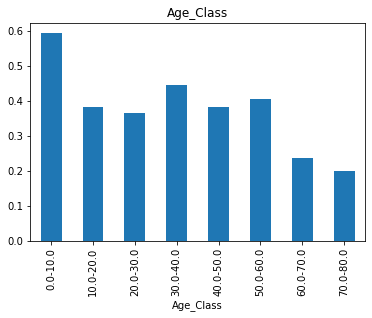

In [22]:
show_survival('Age_Class')

#### Extração do título de cada pessoa

Sex       female  male
Title                 
Capt           0     1
Col            0     4
Countess       1     0
Don            0     1
Dona           1     0
Dr             1     7
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    61
Miss         260     0
Mlle           2     0
Mme            1     0
Mr             0   757
Mrs          197     0
Ms             2     0
Rev            0     8
Sir            0     1


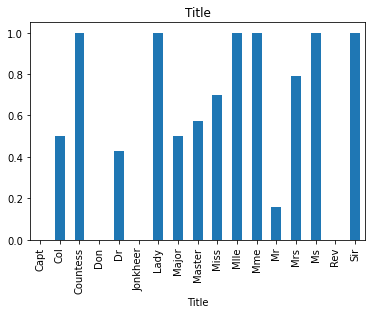

In [23]:
combined['Title'] = combined.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
print(pd.crosstab(combined['Title'], combined['Sex']))
show_survival('Title')

#### Classificação da tarifa em variável categórica

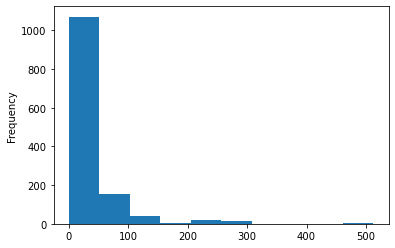

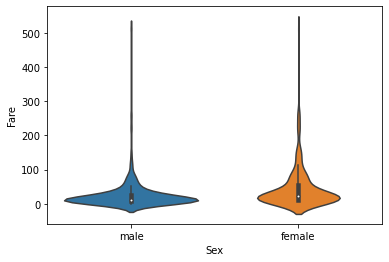

In [24]:
combined = classify(combined, 'Fare', 8)
combined.Fare.plot.hist()
plt.show()
ax = sns.violinplot(x="Sex", y="Fare", data=train_data)

Existe uma grande concentração na 1ª faixa de tarifas, pelo que é melhor classificar os intervalos em percentis

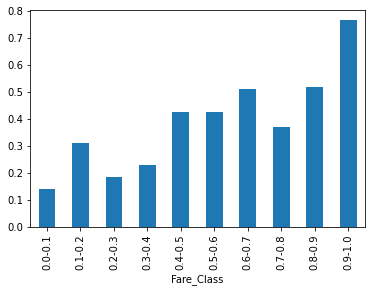

In [25]:
combined.drop(columns = 'Fare_Class', inplace = True)
combined['Fare_Percentile'] = combined.Fare.rank(pct = True) 
combined = classify(combined, 'Fare_Percentile', 10).rename(columns = {'Fare_Percentile_Class': 'Fare_Class'})
combined.query('type == "train"').groupby('Fare_Class').apply(survival).plot.bar()

#### Classificação da cabina

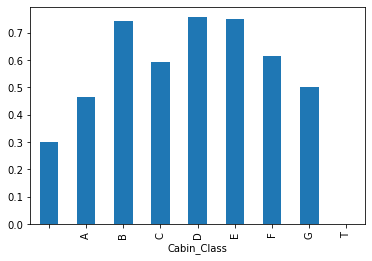

In [26]:
combined['Cabin_Class'] = combined['Cabin'].map(lambda x: str(x[:1]) if x == x else '')
combined.query('type == "train"').groupby('Cabin_Class').apply(survival).plot.bar()

In [27]:
combined

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type,Age_Class,Title,Fare_Percentile,Fare_Class,Cabin_Class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,20.0-30.0,Mr,0.082951,0.0-0.1,
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,30.0-40.0,Mrs,0.883410,0.8-0.9,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,20.0-30.0,Miss,0.266820,0.2-0.3,
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,30.0-40.0,Mrs,0.834480,0.8-0.9,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,30.0-40.0,Mr,0.299312,0.2-0.3,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test,NaN,Mr,0.299312,0.2-0.3,
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test,30.0-40.0,Dona,0.939602,0.9-1.0,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test,30.0-40.0,Mr,0.082951,0.0-0.1,
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test,NaN,Mr,0.299312,0.2-0.3,


#### 4. Definição de um modelo para prever a sobrevivência

#### 4.1 Modelo 'naive' baseado em regras

In [28]:
combined = combined.merge(solution.rename(columns={'Survived':'Solution'}), on = 'PassengerId', how = 'left')
combined['Prediction'] = combined.apply(lambda x: 1 if (x['Sex'] == 'female' and x['Pclass'] == 1) else 0, axis = 1)
print(sum(combined.query('type == "test"')['Solution']))
print(sum(combined.query('type == "test"')['Prediction']))

155.0
50


In [29]:
train_data = combined.query('type == "train"')
test_data = combined.query('type == "test"')
test_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type,Age_Class,Title,Fare_Percentile,Fare_Class,Cabin_Class,Solution,Prediction
891,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,test,30.0-40.0,Mr,0.192661,0.1-0.2,,0.0,0
892,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,test,40.0-50.0,Mrs,0.027905,0.0-0.1,,1.0,0
893,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,test,60.0-70.0,Mr,0.371560,0.3-0.4,,0.0,0
894,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,test,20.0-30.0,Mr,0.339450,0.3-0.4,,0.0,0
895,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,test,20.0-30.0,Mrs,0.418578,0.4-0.5,,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,test,NaN,Mr,0.299312,0.2-0.3,,0.0,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,test,30.0-40.0,Dona,0.939602,0.9-1.0,C,1.0,1
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,test,30.0-40.0,Mr,0.082951,0.0-0.1,,0.0,0
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,test,NaN,Mr,0.299312,0.2-0.3,,0.0,0


#### Iremos agora avaliar a qualidade das nossas previsões

[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predicted')]

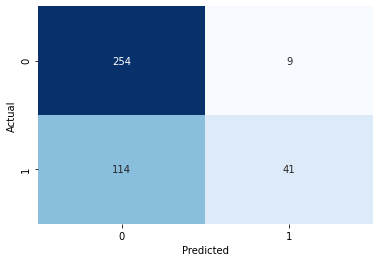

In [30]:
ax = sns.heatmap(confusion_matrix(test_data['Solution'], test_data['Prediction']), cmap='Blues', annot=True, fmt='g', cbar = False)
ax.set(xlabel="Predicted", ylabel = "Actual")

In [31]:
evaluation = pd.crosstab(test_data['Solution'], test_data['Prediction'], rownames = ['Actual'], colnames =['Predicted'], margins = True)
print(evaluation)
print('\n')
precision = evaluation[1][1] / evaluation[1]['All']
recall = evaluation[1][1] / evaluation['All'][1]
accuracy = (evaluation[0][0] + evaluation[1][1]) / evaluation['All']['All']
print(f'Precision: {"{0:.2%}".format(precision)}; Recall: {"{0:.2%}".format(recall)}; Accuracy: {"{0:.2%}".format(accuracy)}\n')

Predicted    0   1  All
Actual                 
0.0        254   9  263
1.0        114  41  155
All        368  50  418


Precision: 82.00%; Recall: 26.45%; Accuracy: 70.57%



![Markdown Logo is here.](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/1200px-Precisionrecall.svg.png)

Para usarmos modelos mais avançados, será necessário processar os dados novamente, pois os modelos só aceitam variáveis numéricas.

In [32]:
combined_numeric = combined.copy()
combined_numeric['Sex'] = combined_numeric['Sex'].map(lambda x: 1 if x == 'female' else 0)
combined_numeric['Embarked'] = combined_numeric['Embarked'].fillna('S').map(lambda x: {'C': 0, 'Q': 1, 'S': 2}[x])
combined_numeric['Cabin_Class'] = combined_numeric['Cabin_Class'].map(lambda x: 0 if x == '' else ord(x))
combined_numeric['Title'] = combined_numeric['Title'].astype('category').cat.codes

In [33]:
train_data = combined_numeric.query('type == "train"')
test_data = combined_numeric.query('type == "test"')
test_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,type,Age_Class,Title,Fare_Percentile,Fare_Class,Cabin_Class,Solution,Prediction
891,892,NaN,3,"Kelly, Mr. James",0,34.5,0,0,330911,7.8292,NaN,1,test,30.0-40.0,13,0.192661,0.1-0.2,0,0.0,0
892,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,1,0,363272,7.0000,NaN,2,test,40.0-50.0,14,0.027905,0.0-0.1,0,1.0,0
893,894,NaN,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,240276,9.6875,NaN,1,test,60.0-70.0,13,0.371560,0.3-0.4,0,0.0,0
894,895,NaN,3,"Wirz, Mr. Albert",0,27.0,0,0,315154,8.6625,NaN,2,test,20.0-30.0,13,0.339450,0.3-0.4,0,0.0,0
895,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,1,1,3101298,12.2875,NaN,2,test,20.0-30.0,14,0.418578,0.4-0.5,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",0,NaN,0,0,A.5. 3236,8.0500,NaN,2,test,NaN,13,0.299312,0.2-0.3,0,0.0,0
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",1,39.0,0,0,PC 17758,108.9000,C105,0,test,30.0-40.0,4,0.939602,0.9-1.0,67,1.0,1
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",0,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,2,test,30.0-40.0,13,0.082951,0.0-0.1,0,0.0,0
1307,1308,NaN,3,"Ware, Mr. Frederick",0,NaN,0,0,359309,8.0500,NaN,2,test,NaN,13,0.299312,0.2-0.3,0,0.0,0


#### 4.2 Decision Tree

Uma árvore de decisão procura utilizar regras para classificar ou prever valores numéricos, através de decisões hierárquicas, designadas por ramos.
No caso apresentado, as mulheres que viajaram em 1ª classe constituem o 1º ramo, mas poderíamos ter aprofundado as decisões seguintes, e mesmo as decisões do outro "ramo", no caso de a observação não ser mulher a viajar em 1ª classe.

Precision: 55.62%; Recall: 57.42%; Accuracy: 67.22%



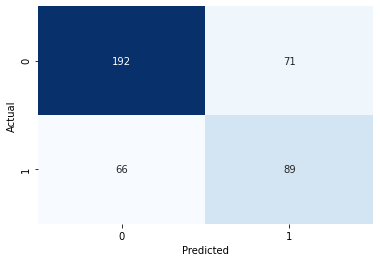

In [34]:
pd.options.mode.chained_assignment = None

features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Title','Fare_Percentile','Cabin_Class']
def prediction_function(model, train_data, test_data):
    model.fit(train_data[features].fillna(0), train_data['Survived'])
    prediction = model.predict(test_data[features].fillna(0))
    test_data.loc[:,'Prediction'] = prediction
    evaluation = pd.crosstab(test_data['Solution'], test_data['Prediction'], rownames = ['Actual'], colnames =['Predicted'], margins = True)
    precision = evaluation[1][1] / evaluation[1]['All']
    recall = evaluation[1][1] / evaluation['All'][1]
    accuracy = (evaluation[0][0] + evaluation[1][1]) / evaluation['All']['All']
    ax = sns.heatmap(confusion_matrix(test_data['Solution'], test_data['Prediction']), cmap='Blues', annot=True, fmt='g', cbar = False)
    ax.set(xlabel="Predicted", ylabel = "Actual")
    print(f'Precision: {"{0:.2%}".format(precision)}; Recall: {"{0:.2%}".format(recall)}; Accuracy: {"{0:.2%}".format(accuracy)}\n')
    # return print(classification_report(test_data['Solution'], test_data['Prediction']))

dt = tree.DecisionTreeClassifier()
prediction_function(dt, train_data, test_data)

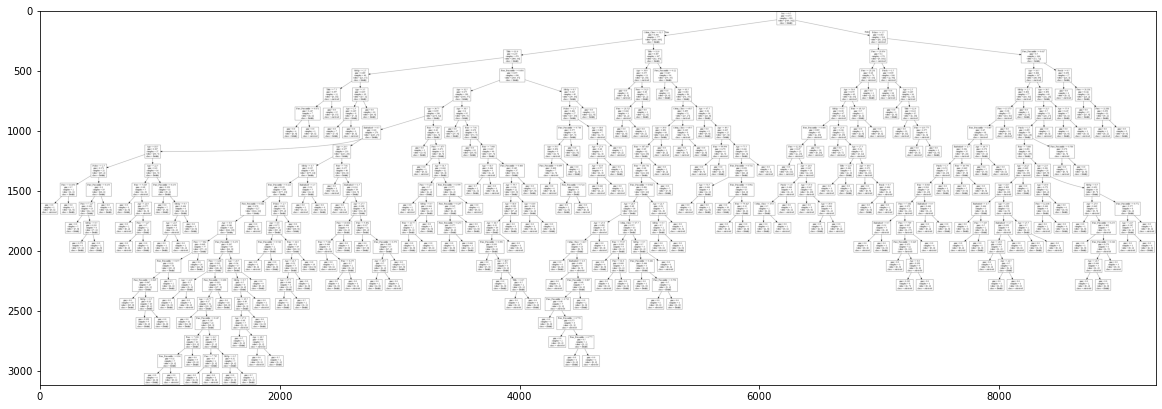

In [35]:
from sklearn.tree import export_graphviz
export_graphviz(dt, 'tree.dot', class_names = ['fatality','survived'], feature_names = features)
! dot -Tpng tree.dot -o tree.png
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
img = cv2.imread('tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

Provavelmente existirá algum overfitting, dada a quantidade de nós, adaptados para este caso específico. 
O passo seguinte seria ajustar os parâmetros do modelo, reduzindo o número de nós possíveis.<br>
![Markdown Logo is here.](https://miro.medium.com/proxy/1*e4Kn-_M_KN2bw-e6kevywA.png)

#### 4.3 Random Forrest

Precision: 64.43%; Recall: 61.94%; Accuracy: 73.21%



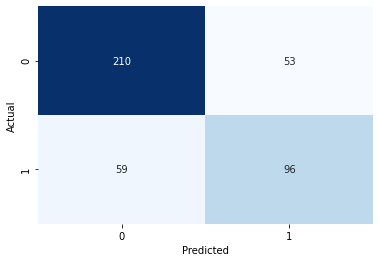

In [36]:
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

prediction_function(rf, train_data, test_data)  

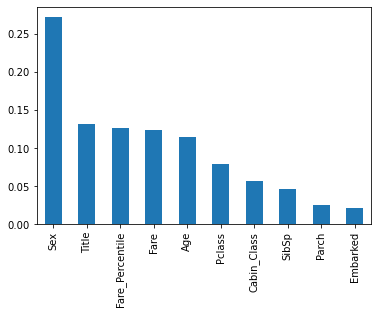

In [37]:
importances = rf.feature_importances_
imp_df = pd.DataFrame(importances, index = features)
imp_df.sort_values(0, ascending = False).plot.bar(legend = False)

#### 4.4 Regressão Logística

Provavelmente existirá algum overfitting, dada a quantidade de nós, adaptados para este caso específico. 
O passo seguinte seria ajustar os parâmetros do modelo, reduzindo o número de nós possíveis.<br>
![Markdown Logo is here.](https://static.javatpoint.com/tutorial/machine-learning/images/logistic-regression-in-machine-learning.png)

Precision: 60.51%; Recall: 61.29%; Accuracy: 70.81%



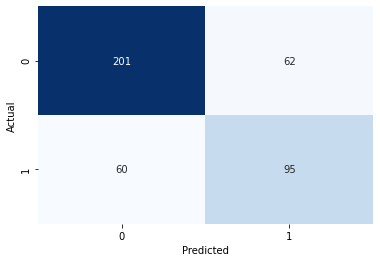

In [38]:
lr = LogisticRegression(random_state = 0, solver = 'lbfgs', max_iter = 10000)
prediction_function(lr, train_data, test_data)

Provavelmente existirá algum overfitting, dada a quantidade de nós, adaptados para este caso específico. 
O passo seguinte seria ajustar os parâmetros do modelo, reduzindo o número de nós possíveis.<br>
![Markdown Logo is here.](https://static.javatpoint.com/tutorial/machine-learning/images/logistic-regression-in-machine-learning.png)